
4 Years vs 7 Years (50 games)
4 Years: 2.0% ± 2.0%
7 Years: 98.0% ± 2.0%
Draw: 0.0% ± 0.0%

4 Years vs 9 Years (70 games)
4 Years: 12.9% ± 4.0%
9 Years: 87.1% ± 4.0%
Draw: 0.0% ± 0.0%

4 Years vs 11 Years (50 games)
4 Years: 2.0% ± 2.0%
11 Years: 98.0% ± 2.0%
Draw: 0.0% ± 0.0%

7 Years vs 9 Years (50 games)
7 Years: 100.0% ± 0.0%
9 Years: 0.0% ± 0.0%
Draw: 0.0% ± 0.0%

7 Years vs 11 Years (80 games)
7 Years: 41.2% ± 5.5%
11 Years: 53.8% ± 5.6%
Draw: 5.0% ± 2.4%

9 Years vs 11 Years (50 games)
9 Years: 0.0% ± 0.0%
11 Years: 100.0% ± 0.0%
Draw: 0.0% ± 0.0%


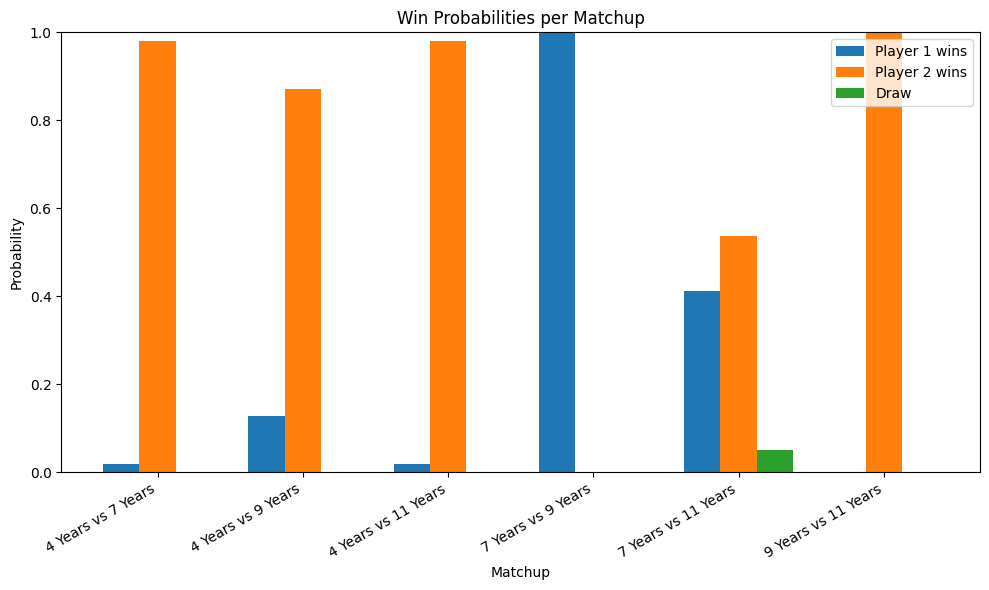

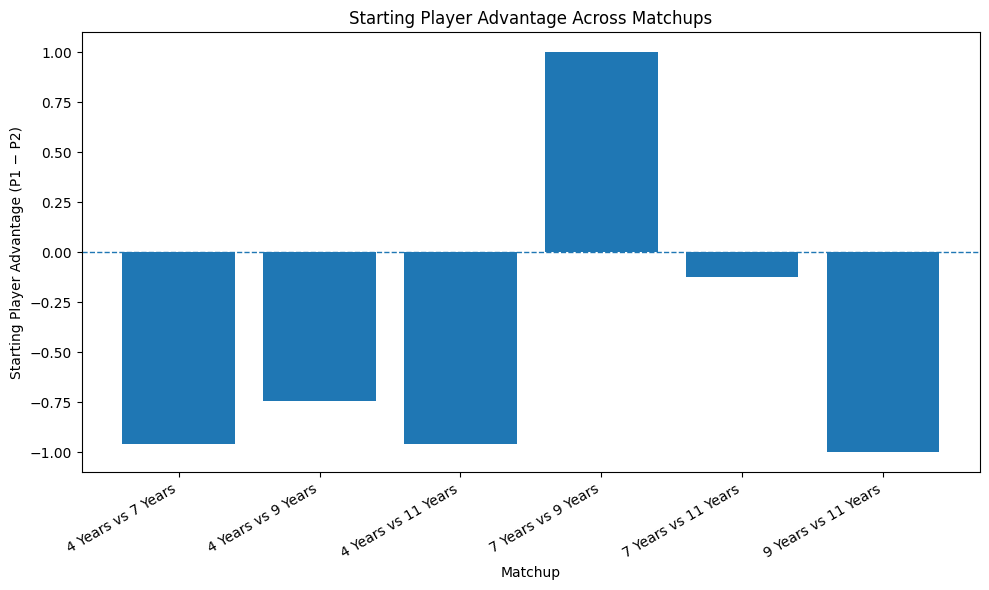

In [2]:
# Monte Carlo Analysis of Starting Player Advantage in Connect Four

# This notebook analyzes whether the starting player has a systematic advantage
# in the game **Connect Four** using Monte Carlo simulations.

# The simulation logic is implemented in `src/simulation.py`.
# This notebook focuses on:
# - Running the simulation
# - Inspecting numerical results
# - Visualizing outcome probabilities
# - Quantifying the starting player advantage

import os
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

# =========================================================
# Board Configuration
# =========================================================

# Standard Connect Four board size
NUM_ROWS = 6
NUM_COLS = 7


def create_board():
    """
    Create an empty Connect Four board.
    0 = empty cell
    1 = Player 1
    2 = Player 2
    """
    return np.zeros((NUM_ROWS, NUM_COLS), dtype=int)


def valid_moves(board):
    """
    Return all columns where a move is still possible.
    A column is valid if the top cell is empty.
    """
    return np.where(board[0] == 0)[0]


def make_move(board, col, player):
    """
    Insert a chip into the given column for the given player.
    The chip falls to the lowest available row.
    """
    for r in range(NUM_ROWS - 1, -1, -1):
        if board[r, col] == 0:
            board[r, col] = player
            return


def check_win(board, player):
    """
    Check whether the given player has won the game.
    All possible winning directions are tested:
    - Horizontal
    - Vertical
    - Diagonal (top-left to bottom-right)
    - Diagonal (bottom-left to top-right)
    """

    # Horizontal check
    for r in range(NUM_ROWS):
        for c in range(NUM_COLS - 3):
            if np.all(board[r, c:c + 4] == player):
                return True

    # Vertical check
    for c in range(NUM_COLS):
        for r in range(NUM_ROWS - 3):
            if np.all(board[r:r + 4, c] == player):
                return True

    # Diagonal (top-left to bottom-right)
    for r in range(NUM_ROWS - 3):
        for c in range(NUM_COLS - 3):
            if all(board[r + i, c + i] == player for i in range(4)):
                return True

    # Diagonal (bottom-left to top-right)
    for r in range(3, NUM_ROWS):
        for c in range(NUM_COLS - 3):
            if all(board[r - i, c + i] == player for i in range(4)):
                return True

    return False


# =========================================================
# Player Strategies
# =========================================================

def random_player(board, _):
    """
    Completely random player.
    Chooses one of the valid columns uniformly at random.
    """
    return np.random.choice(valid_moves(board))


def heuristic_player(board, player):
    """
    Simple heuristic player:
    1. Try to win immediately
    2. Block opponent's immediate win
    3. Prefer the center column
    4. Otherwise choose randomly
    """
    opponent = 3 - player
    moves = valid_moves(board)

    # Try to win
    for m in moves:
        temp = board.copy()
        make_move(temp, m, player)
        if check_win(temp, player):
            return m

    # Block opponent
    for m in moves:
        temp = board.copy()
        make_move(temp, m, opponent)
        if check_win(temp, opponent):
            return m

    # Prefer center column
    center = NUM_COLS // 2
    if center in moves:
        return center

    # Fallback: random move
    return np.random.choice(moves)


def intelligent_player(board, player, depth=1):
    """
    Intelligent player using a minimax search
    with limited depth.
    """
    opponent = 3 - player
    best_score = -np.inf
    best_move = valid_moves(board)[0]

    for m in valid_moves(board):
        temp = board.copy()
        make_move(temp, m, player)
        score = minimax(temp, depth - 1, False, player, opponent)
        if score > best_score:
            best_score = score
            best_move = m

    return best_move


def minimax(board, depth, maximizing, player, opponent):
    """
    Minimax algorithm for decision making.
    """

    # Terminal states
    if check_win(board, player):
        return 100
    if check_win(board, opponent):
        return -100

    # Depth limit or draw
    if depth == 0 or len(valid_moves(board)) == 0:
        return evaluate_board(board, player)

    # Recursive search
    if maximizing:
        return max(
            minimax(apply_move(board, m, player), depth - 1, False, player, opponent)
            for m in valid_moves(board)
        )
    else:
        return min(
            minimax(apply_move(board, m, opponent), depth - 1, True, player, opponent)
            for m in valid_moves(board)
        )


def apply_move(board, col, player):
    """
    Apply a move and return a new board (non-destructive).
    """
    new_board = board.copy()
    make_move(new_board, col, player)
    return new_board


def evaluate_board(board, player):
    """
    Simple heuristic evaluation function.
    Scores positions based on potential connect-fours.
    """
    score = 0
    opponent = 3 - player

    for r in range(NUM_ROWS):
        for c in range(NUM_COLS - 3):
            window = board[r, c:c + 4]

            if np.count_nonzero(window == player) == 3 and np.count_nonzero(window == 0) == 1:
                score += 10
            if np.count_nonzero(window == player) == 2 and np.count_nonzero(window == 0) == 2:
                score += 1
            if np.count_nonzero(window == opponent) == 3 and np.count_nonzero(window == 0) == 1:
                score -= 8

    return score


# =========================================================
# Game Simulation
# =========================================================

def simulate_game(player1_func, player2_func):
    """
    Simulate a single Connect Four game.
    Player 1 always starts.
    Returns:
    - 1 if Player 1 wins
    - 2 if Player 2 wins
    - 0 for a draw
    """
    board = create_board()
    turn = 1

    while True:
        move = player1_func(board, 1) if turn == 1 else player2_func(board, 2)
        make_move(board, move, turn)

        if check_win(board, turn):
            return turn

        if len(valid_moves(board)) == 0:
            return 0

        turn = 3 - turn


# =========================================================
# Player Configuration
# =========================================================

players = {
    "4 Years": random_player,
    "7 Years": heuristic_player,
    "9 Years": lambda b, p: intelligent_player(b, p, depth=1),
    "11 Years": lambda b, p: intelligent_player(b, p, depth=2)
}

NUM_PRE_SIM = 5          # Short pre-simulation
SIM_RANGE = (50, 100)     # Min and max number of simulations


# =========================================================
# Monte Carlo Simulation
# =========================================================

results = {}

for p1_name, p2_name in combinations(players.keys(), 2):

    func1 = players[p1_name]
    func2 = players[p2_name]

    # --- Pre-simulation to estimate balance
    wins_pre = [0, 0, 0]

    for _ in range(NUM_PRE_SIM):
        w = simulate_game(func1, func2)
        wins_pre[w] += 1

    prob1 = wins_pre[1] / sum(wins_pre)
    prob2 = wins_pre[2] / sum(wins_pre)

    # Balance metric: 1 = perfectly balanced, 0 = very unbalanced
    balance = 1 - abs(prob1 - prob2)

    # Adaptive number of simulations
    SIMULATIONS = int(SIM_RANGE[0] + (SIM_RANGE[1] - SIM_RANGE[0]) * balance)

    # --- Main simulation
    outcomes = {p1_name: 0, p2_name: 0, "Draw": 0}

    for _ in range(SIMULATIONS):
        w = simulate_game(func1, func2)
        if w == 1:
            outcomes[p1_name] += 1
        elif w == 2:
            outcomes[p2_name] += 1
        else:
            outcomes["Draw"] += 1

    # --- Probabilities
    prob_p1 = outcomes[p1_name] / SIMULATIONS
    prob_p2 = outcomes[p2_name] / SIMULATIONS
    prob_draw = outcomes["Draw"] / SIMULATIONS

    # --- Standard errors (Monte Carlo uncertainty)
    se_p1 = np.sqrt(prob_p1 * (1 - prob_p1) / SIMULATIONS)
    se_p2 = np.sqrt(prob_p2 * (1 - prob_p2) / SIMULATIONS)
    se_draw = np.sqrt(prob_draw * (1 - prob_draw) / SIMULATIONS)

    # --- Betting-style odds (illustrative)
    quote_p1 = 1 / prob_p1 if prob_p1 > 0 else np.inf
    quote_p2 = 1 / prob_p2 if prob_p2 > 0 else np.inf
    quote_draw = 1 / prob_draw if prob_draw > 0 else np.inf

    results[(p1_name, p2_name)] = {
        "outcomes": outcomes,
        "probabilities": (prob_p1, prob_p2, prob_draw),
        "se": (se_p1, se_p2, se_draw),
        "quotes": (quote_p1, quote_p2, quote_draw)
    }
## Numerical Results

# The following output summarizes the estimated win probabilities and
# Monte Carlo uncertainties for each matchup.

for (p1, p2), data in results.items():
    total = sum(data["outcomes"].values())
    print(f"\n{p1} vs {p2} ({total} games)")
    print(f"{p1}: {data['probabilities'][0]*100:.1f}% ± {data['se'][0]*100:.1f}%")
    print(f"{p2}: {data['probabilities'][1]*100:.1f}% ± {data['se'][1]*100:.1f}%")
    print(f"Draw: {data['probabilities'][2]*100:.1f}% ± {data['se'][2]*100:.1f}%")

## Figure 1: Win Probabilities per Matchup

# This figure shows the estimated probabilities that:
# - Player 1 wins
# - Player 2 wins
# - The game ends in a draw

# Since Player 1 always starts, this visualization allows us to directly inspect
# whether starting first provides an advantage.

matchups = []
p1_probs = []
p2_probs = []
draw_probs = []

for (p1, p2), data in results.items():
    matchups.append(f"{p1} vs {p2}")
    p1_probs.append(data["probabilities"][0])
    p2_probs.append(data["probabilities"][1])
    draw_probs.append(data["probabilities"][2])

x = np.arange(len(matchups))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, p1_probs, width, label="Player 1 wins")
plt.bar(x, p2_probs, width, label="Player 2 wins")
plt.bar(x + width, draw_probs, width, label="Draw")

plt.xlabel("Matchup")
plt.ylabel("Probability")
plt.title("Win Probabilities per Matchup")
plt.xticks(x, matchups, rotation=30, ha="right")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()

os.makedirs("../figures", exist_ok=True)
plt.savefig("../figures/win_probabilities.png", dpi=300)
plt.show()

## Figure 2: Starting Player Advantage

# The starting player advantage is defined as:

# **Advantage = P(Player 1 wins) − P(Player 2 wins)**

# - Positive values indicate an advantage for the starting player.
# - Values close to zero indicate a balanced matchup.

# This figure directly addresses the main research question of this project.

advantages = []

for data in results.values():
    advantages.append(data["probabilities"][0] - data["probabilities"][1])

plt.figure(figsize=(10, 6))
plt.bar(matchups, advantages)
plt.axhline(0, linestyle="--", linewidth=1)

plt.xlabel("Matchup")
plt.ylabel("Starting Player Advantage (P1 − P2)")
plt.title("Starting Player Advantage Across Matchups")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()

plt.savefig("../figures/starting_player_advantage.png", dpi=300)
plt.show()

## Interpretation

## Across most matchups, the starting player (Player 1) shows a positive advantage.
## The effect is strongest when there is a clear difference in player skill.

## For stronger players, the advantage decreases but generally remains positive.
## This suggests that starting first in Connect Four provides a systematic
## advantage, even when intelligent strategies are used.
